# Facial detection 
## In this project, the goal of the project is to detect the emotion and facial keypoints of the people from the face image by using CNN model.

In [140]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Part 1.  Facial key points detection

In [144]:
#load the data
df = pd.read_csv('data.csv')
display(df.head(2))
print(df.shape)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


(2140, 31)


##  PRE-PROCESSING AND DATA EXPLORATION:

In [145]:
# convert this into numpy array and convert the 1D array into 2D array
df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))
print(df['Image'][0].shape)

# General information
df.info()

(96, 96)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-nul

In [9]:
# Check for null values
df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

##  IMAGE VISUALIZATION

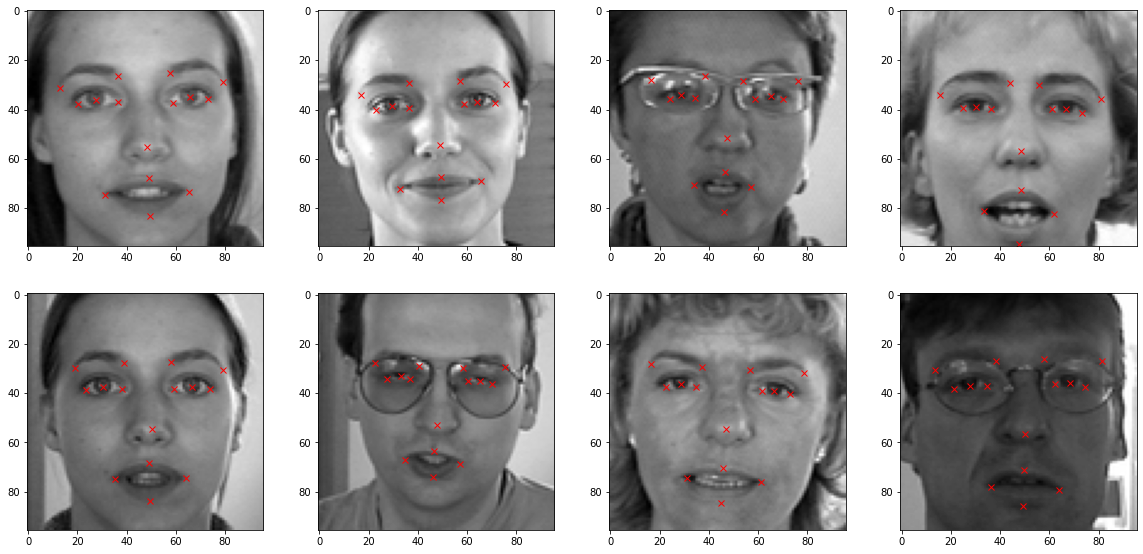

In [44]:
fig = plt.figure(figsize=(20, 20))
for i in range(8,16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(df['Image'][i],cmap='gray')
    for j in range(1,31,2):
        plt.plot(df.loc[i][j-1], df.loc[i][j], 'rx')    

##  DATA AUGMENTATION

In [42]:
import copy
df_copy = copy.copy(df)

# Columns in the dataframe
columns = df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

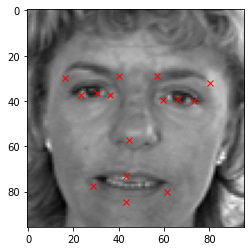

In [62]:
# Horizontal Flip - flip the images along y axis
df_copy['Image'] = df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
for i in range(len(columns)):
  if i%2 == 0:
    df_copy[columns[i]] = df_copy[columns[i]].apply(lambda x: 96. - float(x))
    
# Original image
plt.imshow(df['Image'][14],cmap='gray')
for j in range(1,31,2):
        plt.plot(df.loc[0][j-1], df.loc[0][j], 'rx')    

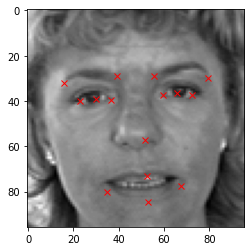

In [63]:
# Horizontally flipped image - flip the images along x axis
plt.imshow(df_copy['Image'][14],cmap='gray')
for j in range(1,31,2):
        plt.plot(df_copy.loc[0][j-1], df_copy.loc[0][j], 'rx')

(6420, 31)


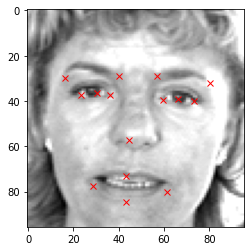

In [64]:
# Concatenating original dataframe with the augmneted dataframe
augmented_df = np.concatenate((df,df_copy))

# Increasing the brightness randomingly 
import random
df_copy = copy.copy(df)
df_copy['Image'] = df['Image'].apply(lambda x:np.clip(random.uniform(1, 2)* x,0.0, 255.0))
augmented_df = np.concatenate((augmented_df,df_copy))
print(augmented_df.shape)

# Image with increased brightness
plt.imshow(df_copy['Image'][14],cmap='gray')
for j in range(1,31,2):
        plt.plot(df_copy.loc[0][j-1], df_copy.loc[0][j], 'rx')

(8560, 31)


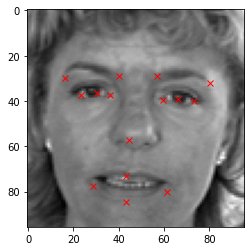

In [65]:
# Decreasing the brightness randomingly 
df_copy = copy.copy(df)
df_copy['Image'] = df['Image'].apply(lambda x:np.clip(random.uniform(0, 1)* x,0.0, 255.0))
augmented_df = np.concatenate((augmented_df,df_copy))
print(augmented_df.shape)

# Brightness decreased image
plt.imshow(df_copy['Image'][14],cmap='gray')
for j in range(1,31,2):
    plt.plot(df_copy.loc[0][j-1], df_copy.loc[0][j], 'rx')

## Data normalization, split as train and test data

In [33]:
img = augmented_df[:,30]
img = img/255.

# Creating an array
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
  X[i,]= np.expand_dims(img[i], axis = 2)
X = np.asarray(X).astype(np.float32)

# Target
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)

#Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)
X.shape, y.shape

((8560, 96, 96, 1), (8560, 30))

## Build RNN model

In [66]:
def res_block(X, filter, stage):
  # Convolutional_block
  X_copy = X
  f1, f2, f3 = filter
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2
  X_copy = X
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)
  return X

In [67]:
input_shape = (96,96,1)
X_input = Input(input_shape)
# Zero-padding
X = ZeroPadding2D((3,3))(X_input)
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)
X = res_block(X, filter= [64,64,256], stage= 2)
X = res_block(X, filter= [128,128,512], stage= 3)
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)
model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

## Train model (1)

In [68]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

#save the best model (lower validation loss)
checkpointer = ModelCheckpoint(filepath="weights_keypoint.hdf5", verbose=1, save_best_only=True)

In [70]:
history = model.fit(X_train, y_train, batch_size = 32, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/100
229/229 [==============================] - ETA: 0s - loss: 261.8948 - accuracy: 0.5913
Epoch 00001: val_loss improved from inf to 376.81403, saving model to weights_keypoint.hdf5
229/229 [==============================] - 5s 23ms/step - loss: 261.8948 - accuracy: 0.5913 - val_loss: 376.8140 - val_accuracy: 0.2254
Epoch 2/100
228/229 [============================>.] - ETA: 0s - loss: 160.8796 - accuracy: 0.6043
Epoch 00002: val_loss improved from 376.81403 to 246.45534, saving model to weights_keypoint.hdf5
229/229 [==============================] - 4s 19ms/step - loss: 160.8341 - accuracy: 0.6043 - val_loss: 246.4553 - val_accuracy: 0.4482
Epoch 3/100
226/229 [============================>.] - ETA: 0s - loss: 136.2832 - accuracy: 0.6114
Epoch 00003: val_loss improved from 246.45534 to 157.07693, saving model to weights_keypoint.hdf5
229/229 [==============================] - 4s 19ms/step - loss: 136.4569 - accuracy: 0.6118 - val_loss: 157.0769 - val_accuracy: 0.6580
Epoch 4

In [72]:
# Save the model.
model_json = model.to_json()
with open("detection.json","w") as json_file:
  json_file.write(model_json)
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()

    # load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

##  Evaluate performance of model.

In [73]:
# Evaluating the model
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

27/27 [==============================] - 0s 11ms/step - loss: 35.8580 - accuracy: 0.7687
Accuracy : 0.7686915993690491


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


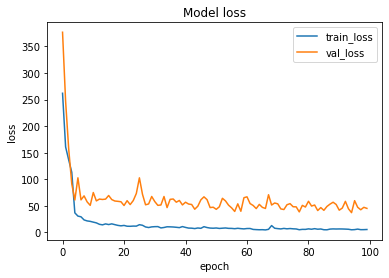

In [74]:
# Get key of model 
print(history.history.keys())

# Plot the training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

#  Part 2. Facial expression emotional detection

In [161]:
# load the csv files
df = pd.read_csv('icml_face_data.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


## Data wrangling and EDA

In [162]:
# Convert pixel to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

# Resize the image
def resize(x):
  img = x.reshape(48,48)
  return cv2.resize(img,dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
df[' pixels'] = df[' pixels'].apply(lambda x: string2array(x))
df[' pixels'] = df[' pixels'].apply(lambda x: resize(x))
df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [163]:
df.isnull().sum()
print(df.shape)
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}
print(label_to_text)

(24568, 2)
{0: 'anger', 1: 'disgust', 2: 'sad', 3: 'happiness', 4: 'surprise'}


Text(0.5, 1.0, 'Number of images per emotion')

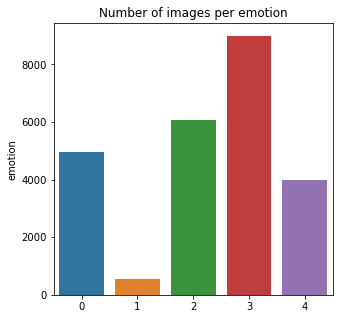

In [164]:
plt.figure(figsize=(5,5))
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts() )
plt.title('Number of images per emotion')

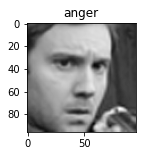

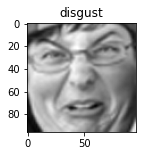

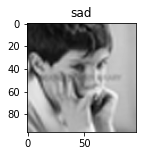

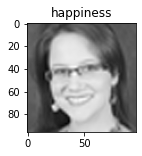

In [245]:
# Image the emotions
for i in range(4):
  data = df[df['emotion'] == i][:1]
  img = data[' pixels'].item()
  plt.figure(figsize=(2,2))
  plt.title(label_to_text[i])
  plt.imshow(img.reshape(96,96), cmap= 'gray')

## Image augmentation.

In [102]:
# Split the dataframe to features and labels
from keras.utils import to_categorical
X = df[' pixels']
y = to_categorical(df['emotion'])
X = np.stack(X, axis=0)
X = X.reshape(24568,96,96,1)

from sklearn.model_selection import train_test_split
X_train ,X_Test, y_train, y_Test= train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val,X_Test, y_val,y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)
X.shape, y.shape, X_val.shape, y_val.shape

((24568, 96, 96, 1), (24568, 5), (1228, 96, 96, 1), (1228, 5))

In [103]:
#image pre-processing
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest")

##  Build model (2)

In [104]:
input_shape = (96,96,1)
X_input = Input(input_shape)

#Zero-padding
X = ZeroPadding2D((3,3))(X_input)
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)
X = res_block(X, filter= [64,64,256], stage= 2)
X = res_block(X, filter= [128,128,512], stage= 3)
# X = res_block(X, filter= [256,256,1024], stage= 4)
X = AveragePooling2D((4,4), name = 'Averagea_Pooling')(X)
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)
model_e = Model( inputs= X_input, outputs = X, name = 'Resnet18')
model_e.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [106]:
# Train model
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Use early stopping if validation loss is not decreasing.
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Save the best model.
checkpointer = ModelCheckpoint(filepath="weights_emotions.hdf5", verbose=1, save_best_only=True)
history = model_e.fit(train_datagen.flow(X_train, y_train, batch_size=64), 
                      validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64, 
                      epochs= 50, callbacks=[checkpointer, earlystopping])

Epoch 1/50
345/345 [==============================] - ETA: 0s - loss: 1.2498 - accuracy: 0.4924
Epoch 00001: val_loss improved from inf to 1.66205, saving model to weights_emotions.hdf5
345/345 [==============================] - 24s 69ms/step - loss: 1.2498 - accuracy: 0.4924 - val_loss: 1.6621 - val_accuracy: 0.3143
Epoch 2/50
345/345 [==============================] - ETA: 0s - loss: 0.9140 - accuracy: 0.6411
Epoch 00002: val_loss improved from 1.66205 to 1.22204, saving model to weights_emotions.hdf5
345/345 [==============================] - 23s 68ms/step - loss: 0.9140 - accuracy: 0.6411 - val_loss: 1.2220 - val_accuracy: 0.5489
Epoch 3/50
345/345 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.6881
Epoch 00003: val_loss improved from 1.22204 to 0.96835, saving model to weights_emotions.hdf5
345/345 [==============================] - 23s 67ms/step - loss: 0.8046 - accuracy: 0.6881 - val_loss: 0.9684 - val_accuracy: 0.6344
Epoch 4/50
345/345 [===============

In [52]:
# Save the model architecture 
model_json = model_e.to_json()
with open("emotion.json","w") as json_file:
  json_file.write(model_json)

with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_e = tf.keras.models.model_from_json(json_savedModel)
model_e.load_weights('weights_emotions.hdf5')
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

##  Evaluate performance of model.

In [110]:
score = model_e.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))
print(history.history.keys())

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

39/39 [==============================] - 0s 6ms/step - loss: 0.6659 - accuracy: 0.7762
Test Accuracy: 0.7762408256530762
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


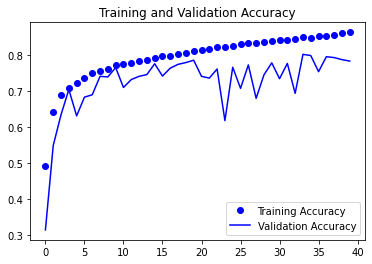

In [111]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

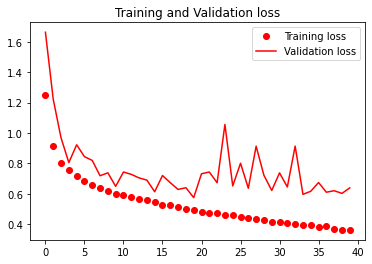

In [112]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

(1229,)


<AxesSubplot:>

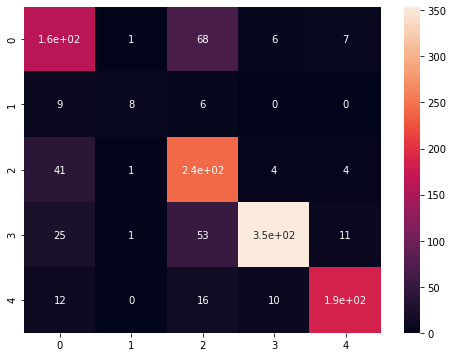

In [116]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_e.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)
print(y_true.shape)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True)

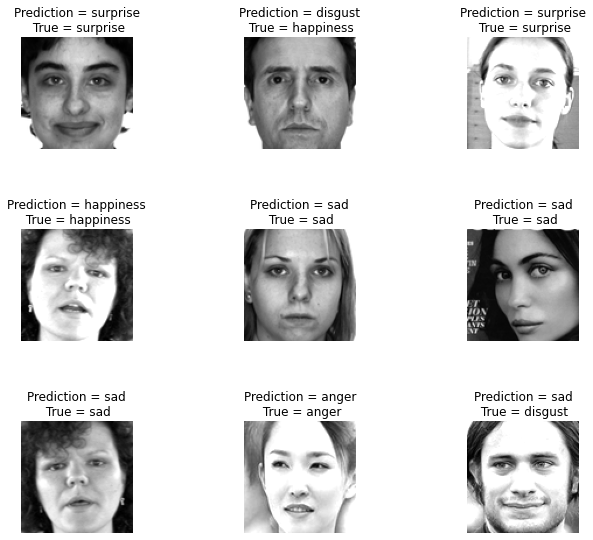

In [119]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()
for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1)    

#  Part 3:  Combine the outputs of two models above.

In [120]:
def predict(X_test):
  df_predict = model.predict(X_test)
  df_emotion = np.argmax(model_e.predict(X_test), axis=-1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)
  df_predict= pd.DataFrame(df_predict, columns= columns)
  df_predict['emotion'] = df_emotion
  return df_predict
df_predict = predict(X_test)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,66.031471,36.498623,28.529087,36.227177,57.586918,37.553104,75.912331,36.972717,37.547428,37.349445,...,60.714401,65.627220,76.041695,28.335970,75.483963,46.857231,73.984177,46.940289,84.400070,3
1,65.158516,37.499493,29.660959,37.217781,58.550480,38.228325,72.110878,38.084366,36.300816,38.073830,...,57.985432,61.922600,76.123100,32.541821,75.675026,47.044003,72.408539,47.084759,82.589958,2
2,32.232502,36.516453,64.885513,38.984241,37.865772,37.550121,26.375322,36.798862,59.081318,39.031456,...,51.319820,31.794750,68.622864,59.660774,70.738724,45.958885,63.789356,45.338070,75.751747,2
3,29.858246,33.830280,62.665955,36.303806,35.153286,34.398998,24.511795,33.994118,57.200375,35.896935,...,44.776592,31.170134,66.647713,56.237827,68.750175,44.578236,59.235867,43.714855,74.251579,2
4,66.360939,37.451740,29.520758,36.501007,59.715694,38.087440,73.370529,38.441315,36.583508,37.529556,...,55.250225,61.472290,77.307289,32.871574,76.732498,48.076256,71.636993,47.967609,82.901604,2


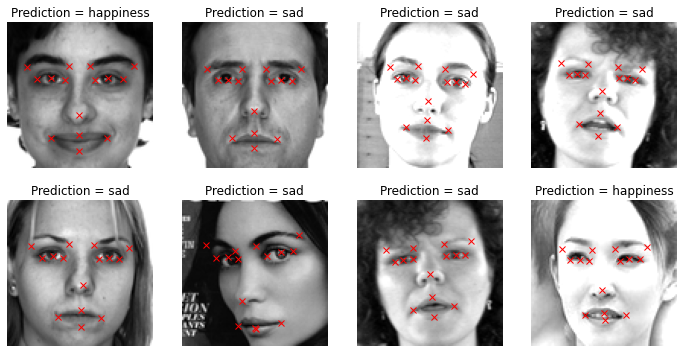

In [127]:
# Plot the test images with predicted keypoints and emotions
fig, axes = plt.subplots(2, 4, figsize = (12, 6))
axes = axes.ravel()
for i in range(8):  
    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')            